In [1]:
%matplotlib inline

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

from typing import Callable, Dict, Tuple, List


In [2]:
from sklearn.datasets import load_boston

### preparation

In [3]:
boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [4]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [6]:
TEST_ALL = False

## Neural network regression

After a manual linear regression, the model can be extended to learn nonlinear relationships. The idea is, that we perform many linear regression, feed the results in a nonlinear activation function and perfom as the last step another linear regression to predict the outcome. 

Sigmoid is used as a nonlinear function. For more information, go the the activation function notebook. The advantage, and why it is used here, that the deriviative also can be expressed with the sigmoid function.

$$ \frac{\partial \sigma}{\partial u} = \sigma (x) * (1 - \sigma (x)) $$

In [7]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

In [8]:
Batch = Tuple[ndarray, ndarray]


def permute_data(X: ndarray, y: ndarray):
    """
    Permute X and y, using the same permutation, along axis=0
    """
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]


def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    """
    Generate batch from X and y, given a start position
    """
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch


def mae(preds: ndarray, actuals: ndarray):
    """
    Compute mean absolute error.
    """
    return np.mean(np.abs(preds - actuals))


def rmse(preds: ndarray, actuals: ndarray):
    """
    Compute root mean squared error.
    """
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [9]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    """
    Initialize weights during the forward pass for step-by-step neural network model.
    """
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

## Forward pass

This is the forward pass for the neural network. It consists of 2 layers (W1+B1, W2+b2) and is connected with a nonlinear activation function. It calculates the prediction P and returns the loss. 

In [10]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    """
    Compute the forward pass and the loss for the step-by-step 
    neural network model.     
    """
    # transform input features with weight matrix
    M1 = np.dot(X, weights['W1'])

    #add bias
    N1 = M1 + weights['B1']

    # activation function
    O1 = sigmoid(N1)
    
    # repear previous steps
    M2 = np.dot(O1, weights['W2'])

    # prediction
    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

## Backward pass

We compute the partial derivatives of each operation from the forward pass. Therefor we are tracing backward through the forward pass and  multiply  them to get the gradients of the loss with respect to each of the weights.

In [11]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    """
    Compute the partial derivatives of the loss with respect to each of the parameters in the neural network.
    """    

    dLdP = -(forward_info['y'] - forward_info['P'])
    dPdM2 = np.ones_like(forward_info['M2'])
    dPdB2 = np.ones_like(weights['B2'])

    dLdM2 = dLdP * dPdM2    

    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))    
    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    # gradients of the loos
    dLdW2 = np.dot(dM2dW2, dLdP)
    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    
    dN1dB1 = np.ones_like(weights['B1'])
    dN1dM1 = np.ones_like(forward_info['M1'])
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdN1 = dLdO1 * dO1dN1
    dLdM1 = dLdN1 * dN1dM1
    
    # gradients of the loos
    dLdW1 = np.dot(dM1dW1, dLdM1)
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)    

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

The dataset has 13 features. For simplicity, I choose here also 13 neurons for the hidden layer; 1 linear regression /neuron for each feature. 

Compared to the linear regressionthe weights dictionary has 4 keys instead of two. Even for more complex architectures , the mathematical principles and high-level training procedures stay thesame as in simple models.

In [12]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)

    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        # update the gradients
        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [13]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]) -> ndarray:
    '''
    Generate predictions from the step-by-step neural network model. 
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [14]:
if TEST_ALL:
    num_iter = 10000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [15]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

## Learning rate tuning

In [16]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = learning_rate,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return r2_score(y_test, preds)

In [17]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [18]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [19]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

## Evaluating best model

In [20]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

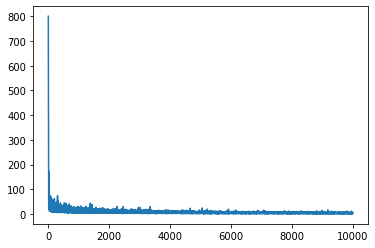

In [21]:
plt.plot(list(range(10000)), losses)

In [22]:
preds = predict(X_test, weights)

In [23]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 2.5951 
Root mean squared error: 3.8851


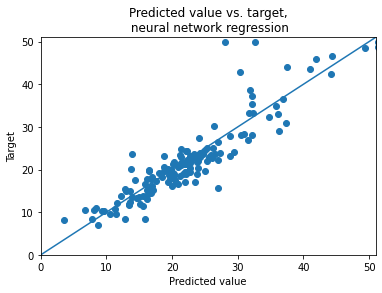

In [24]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target,\n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])

In [25]:
np.round(np.mean(np.array(np.abs(preds - y_test))), 4)

2.5951

In [26]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

15.0943

## Theoretical relationship between most important feature and target

In [27]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

Text(0.5, 1.0, 'Most important feature vs. target and predictions,\n neural network regression')

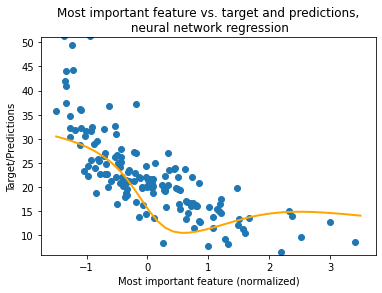

In [28]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n neural network regression")

The model performs better than the linear regerssion. This is quite simple, since the model itself is not constraint to a linear relationship anymore as you see above.

So the model learns nonlinear relationships and it also learns relationships between combinations of our original features and our target.  

## Investigation of most important features

Most important combinations of features are the two with absolute values of greater than 9

In [29]:
weights['W2']

array([[  6.88181019],
       [  7.39079869],
       [  5.63204199],
       [  7.23579823],
       [  7.62525138],
       [  6.75401976],
       [  3.32508428],
       [  9.72867071],
       [  5.6010739 ],
       [-10.24687493],
       [  5.56446463],
       [  5.6762053 ],
       [ -4.40884115]])

These are at index 7 and index 9. Here are the combinations themselves:

In [30]:
weights['W1'][7]

array([-3.35318091e+00, -4.67745141e-01,  5.48100312e-01, -8.80425014e-02,
        1.75362999e+00, -5.31114287e+00, -9.43127649e-01, -5.87300786e-01,
       -1.23411490e-03,  1.13747060e+00, -5.28009349e-01,  1.15916033e+00,
        1.60070328e+00])

In [31]:
weights['W1'][9]

array([-2.6785258 ,  3.92130586,  2.23977236, -3.63226802, -0.22408348,
        3.18889016,  0.3231029 ,  0.43162245, -1.97327924,  0.24029253,
       -1.44634709, -0.50844719,  1.55610834])